### Members:
- 109065511 張宜禎
- 109062562 蔡哲維
- 108065425 丘騏銘

# 5 descriptions with 5 noises result

The images below are sample inference results of our model (presented in `DL_comp3_13_model.ipynb` at 600 epochs) using 5 descriptions, each with 5 different noise values. We can see that the generated images more or less has the same characteristics even though they start with different noise values. The 5 descriptions are as follows:

1. this flower has thick red petals as its main feature

2. the petals of the flower are pink in color while the filaments are also pink

3. the flower has bright orange petals with a yellow inner ring

4. the petals on this flower are white with yellow stamen

5. this flower has a broad center of many brown stamen surrounded by many long narrow pointy yellow petals

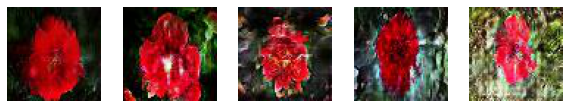

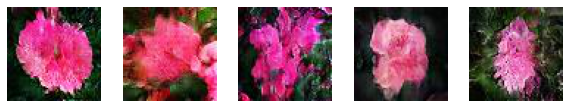

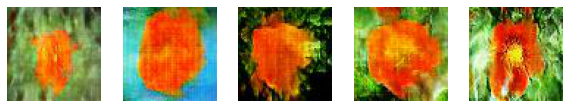

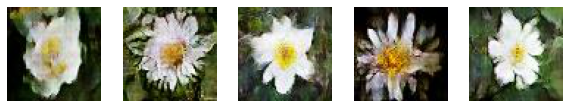

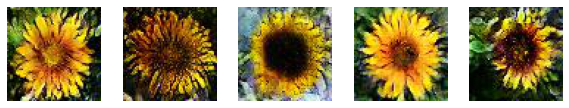

In [12]:
import matplotlib.pyplot as plt

idx = [7727, 3743, 2258, 6216, 5406]

count = 0

for i in range(5):
    fig = plt.figure(figsize=(10, 10))
    for j in range(1,6):
        path = './img_in_report/inference_{:04d}_{:d}.jpg'.format(idx[i],j)
        fake_iamge = plt.imread(path)
        plt.subplot(5, 5, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')
        count+=1

# Text Processing

In this competition, we tried to use BERT-large to transform the captions into embeddings. The first thing we do is to reverse the indices to texts. Later on, we use BERT tokenizer to turn the texts into BERT index tokens, and then send the sequences into BERT.

After getting the embeddings generated by BERT, we choose the embeddings which belong to \[CLS\] tokens as the caption information for training the conditional GAN. Since the \[CLS\] embedding can be used as the information to do classification tasks, we think it contains the overall information of the sentence.

Other things we tried:

- Using XLNet embeddings

In [ ]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained(
    'bert-large-uncased', 
    do_lower_case=False,
    do_basic_tokenize=False
)
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

def turn_to_bert_embedding(string_list):
    try:
        bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
        bert_outputs = bert_model(bert_inputs)
        caption_embedding = bert_outputs.last_hidden_state[:,0]
    except(ValueError):
        print(string_list)
    return caption_embedding.numpy().tolist()

# Image Processing and Generating Dataset

In this step, we use all the captions, so there will be 70495 image-caption pair. Besides generating the original image-caption pair, we sent the pairs into two data augmentation functions. The first one is flipping the images horizontally. The second one is tuning the brightness randomly. There will be 211485 image-caption pairs in the dataset. Additionally, all images are also rescaled to values within \[-1, 1\].

Other things we tried:
- Cropping images
- Flipping images vertically
- Random selection of caption (e.g. 5 captions per image)

In [ ]:
def training_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. - 1.
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

def flip_right_left_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. -1.
    img = tf.image.flip_left_right(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding


def adjust_brightness_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.random_brightness(img, 0.2, 2)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. -1.
    img = tf.image.flip_up_down(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

# GAN architecture

We use DC layers as the main part of the generator, since in the paper, the author used the DC GAN architecture, too. We modified the discriminator to not include BatchNormalization layers since we use WGAN-GP loss as recommended in the WGAN-GP paper.

Other things we tried:

- Adding an extra GRU layer to process text embeddings before being fed to the DC layers in the generator
- Implementing BatchNormalization layers when training with cross entropy loss

## Generator

The generator will receive two vectors. One is the embedding generated by BERT, and the other is the noise generated from the normal distribution. Once the generator receive the embedding, it first compress the 1024-dimension vector into 128-dimension vector. Then the noise will be concatenated with the compressed embedding. 

The concatenated vector will be sent into a Dense layer, which generates a 4\*4\*1024-dimension vector. The result will be reshaped and sent into several DC layers, and become a 64\*64\*3 image.

## Discriminator

The discriminator will receive image matrices and embedding vectors. The embedding vector also will be compressed into 128 dimensions.

The image matrix will go through several convolution layers, and become a 4\*4\*1024 tensor.

The tensor will be concatenated with the compressed embedding as the description in the paper. The result will go through a 1\*1 convolution layer again, and then will be flatten and sent in to a dense layer. The output of the dense layer means that if the discriminator think the input is true or false. 

In [ ]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.to_4_4_1024 = tf.keras.layers.Dense(4*4*1024)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        self.dc1 = tf.keras.layers.Conv2DTranspose(
            filters = 512,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc2 = tf.keras.layers.Conv2DTranspose(
            filters = 256,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc3 = tf.keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc4 = tf.keras.layers.Conv2DTranspose(
            filters = 3,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        
        
    def call(self, noise_z, text, training):
        # compress the embedding
        text = self.compress(text)
        text = self.lr1(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        
        # To 4*4*1024
        text_concat = self.to_4_4_1024(text_concat)
        text_concat = tf.reshape(text_concat, [-1, 4, 4, 1024])
        text_concat = self.bn1(text_concat,training=training)
        text_concat = self.lr2(text_concat)
        
        # To 8*8*512
        text_concat = self.dc1(text_concat)
        text_concat = self.bn2(text_concat,training=training)
        text_concat = self.lr3(text_concat)
        
        # To 16*16*256
        text_concat = self.dc2(text_concat)
        text_concat = self.bn3(text_concat,training=training)
        text_concat = self.lr4(text_concat)
        
        # To 32*32*128
        text_concat = self.dc3(text_concat)
        text_concat = self.bn4(text_concat,training=training)
        text_concat = self.lr5(text_concat)
        
        # To 64*64*3
        text_concat = self.dc4(text_concat)
        
        output = tf.nn.tanh(text_concat)
        
        return output

In [ ]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
        
        self.relu = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = (64,64,3))
        
        self.conv2 = tf.keras.layers.Conv2D(
            filters = 256,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv3 = tf.keras.layers.Conv2D(
            filters = 512,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv4 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv5 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 1,
            strides = (1, 1),
            padding = "SAME")
    
    def call(self, img, text, training):
        # Conpress embedding
        text = self.compress(text)
        text = self.relu(text)
        # To 32*32*128
        img = self.conv1(img)
        #img = self.bn1(img,training=training)
        img = self.lr1(img)
        # To 16*16*256
        img = self.conv2(img)
        #img = self.bn2(img,training=training)
        img = self.lr2(img)
        # To 8*8*512
        img = self.conv3(img)
        #img = self.bn3(img,training=training)
        img = self.lr3(img)
        # To 4*4*1024
        img = self.conv4(img)
        #img = self.bn4(img,training=training)
        img = self.lr4(img)
        
        # concatenate image with paired text
        text = tf.expand_dims(text,axis=1)
        text = tf.expand_dims(text,axis=1)
        text = tf.tile(text,multiples=[1,4,4,1])
        img_text = tf.concat([img, text], axis=-1)
        
        img_text = self.conv5(img_text)
        #img_text = self.bn5(img_text,training=training)
        img_text = self.relu2(img_text)
        
        img_text = tf.reshape(img_text, [-1, 4*4*1024])
        
        
        score = self.d(img_text)
        return score

# Loss function

We use WGAN-GP loss from the Improved WGAN paper, with slight modification by adding Gaussian noise (noise from a normal distribution) with decay up to epoch 200 (equal to reciprocal of current epoch) to the images before being processed by the discriminator. Training is also designed so that ratio of training step for Discriminator:Generator is 5:1.

Other things we tried:
- Adding Gaussian noise to images before passing to discriminator throughout all training epochs
- Using GAN cross entropy loss
- Use TTUR (Two Time-Scale Update Rule) instead of training step ratio (Discriminator LR at 3e-4, Generator LR at 1e-4)
- Adam optimizer momentum tuning (tuning the values for beta_1 and beta_2)

In [ ]:
@tf.function
def DC_D_Train(c1,embed,noise_decay):
    z = tf.random.normal(hparas['BZ']) 

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x_bar = generator(z, embed, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise_decay * tf.random.normal(x_bar.shape)
            x = x + noise_decay * tf.random.normal(x.shape)
            x_hat = x_hat + noise_decay * tf.random.normal(x_hat.shape)

            z0 = discriminator(x_bar, embed, training = True)
            z1 = discriminator(x, embed, training = True)
            z2 = discriminator(x_hat, embed, training = True)

            gradient_penalty = tp_2.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tp.gradient(ld, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

    return lg, ld

@tf.function
def DC_G_Train(c1,embed,noise_decay):
    
    z = tf.random.normal(hparas['BZ'])

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x_bar = generator(z, embed, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise_decay * tf.random.normal(x_bar.shape)
            x = x + noise_decay * tf.random.normal(x.shape)
            x_hat = x_hat + noise_decay * tf.random.normal(x_hat.shape)

            z0 = discriminator(x_bar, embed, training = True)
            z1 = discriminator(x, embed, training = True)
            z2 = discriminator(x_hat, embed, training = True)
            gradient_penalty = tp_2.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tp.gradient(lg, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

    return lg, ld

### Additional results

The result below is for the model we trained without Gaussian noise decay. Gaussian noise is constantly added in all epochs to images before being input to the Discriminator.

We originally want to train the model for 600 epochs, but because of the time limitation, we only train it for 280 epochs.

The reason we do this is that we want to know if the noise can impact the result significantly. However, due to the time limitation, the experiment only run for 280 epochs.

Here are some images generated.

1. this flower has petals that are white with yellow stamen

![Alt text](./noise_until_end-280epochs/inference_6623.jpg)

2. this flower is purple in color with petals that are curled upward

![Alt text](./noise_until_end-280epochs/inference_4081.jpg)

3. this flower is yellow in color with petals that are rounded

![Alt text](./noise_until_end-280epochs/inference_4639.jpg)


4. this flower has a numerous amount of thin bright yellow petals

![Alt text](./noise_until_end-280epochs/inference_6530.jpg)

5. this flower has a wide brown center surrounded by long yellow petals

![Alt text](./noise_until_end-280epochs/inference_5443.jpg)
